# No Reference Metrics

Demonstrate the use of the no-reference metrics: noise power spectrum (NPS), modulation transfer function (MTF), and noise equivalent quanta (NEQ).

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tomopy

from xdesign import *

## Simulate data aqcuisition
Generate a `UnitCircle` standards phantom. For the modulation transfer function (MTF), the radius must be less than 0.5, otherwise the circle touches the edges of the field of view.

In [2]:
NPIXEL = 100

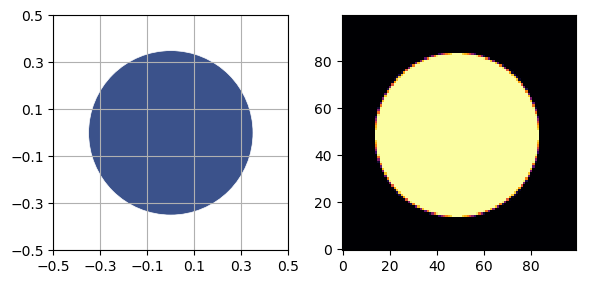

In [3]:
p = UnitCircle(radius=0.35, material=SimpleMaterial(7.23))
sidebyside(p, NPIXEL)
plt.show()

Noise power spectrum (NPS) and Noise Equivalent Quanta (NEQ) are meaningless without noise, so add some poisson noise to the simulated data using `np.random.poisson`. Collecting two sinograms allows us to isolate the noise by subtracting out the circle.

In [4]:
# Define the scan positions using theta and horizontal coordinates
theta, h = np.meshgrid(np.linspace(0, np.pi, NPIXEL, endpoint=False),
                       np.linspace(0, 1, NPIXEL, endpoint=False) - 0.5 + 1/NPIXEL/2)
# Reshape the returned arrays into vectors
theta = theta.flatten()
h = h.flatten()

In [5]:
num_photons = 1e4
# Define a probe that sends 1e4 photons per exposure
probe = Probe(size=1/NPIXEL, intensity=num_photons)
# Measure the phantom
data = probe.measure(p, theta, h)

/home/beams0/DCHING/Documents/xdesign/src/xdesign/geometry/algorithms.py:54: RuntimeWarning: halfspacecirc was out of bounds, -1.1249850495609337e-09
  RuntimeWarning)
/home/beams0/DCHING/Documents/xdesign/src/xdesign/geometry/algorithms.py:54: RuntimeWarning: halfspacecirc was out of bounds, -1.597134646758036e-10
  RuntimeWarning)
/home/beams0/DCHING/Documents/xdesign/src/xdesign/geometry/algorithms.py:54: RuntimeWarning: halfspacecirc was out of bounds, -7.460398965264403e-11
  RuntimeWarning)
/home/beams0/DCHING/Documents/xdesign/src/xdesign/geometry/algorithms.py:54: RuntimeWarning: halfspacecirc was out of bounds, -8.34076696598629e-11
  RuntimeWarning)
/home/beams0/DCHING/Documents/xdesign/src/xdesign/geometry/algorithms.py:54: RuntimeWarning: halfspacecirc was out of bounds, -1.9854995425561128e-10
  RuntimeWarning)


In [6]:
# Add poisson noise to the result.
noisy_data_0 = np.random.poisson(data)
noisy_data_1 = np.random.poisson(data)
# Normalize the data by the incident intensity
normalized_data_0 = noisy_data_0 / num_photons
normalized_data_1 = noisy_data_1 / num_photons

In [7]:
# Linearize the data by taking the negative log
sinoA = -np.log(normalized_data_0).reshape(NPIXEL, NPIXEL).T
sinoB = -np.log(normalized_data_1).reshape(NPIXEL, NPIXEL).T

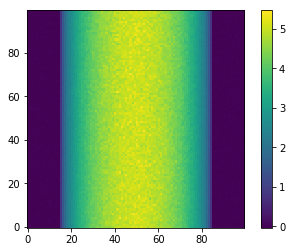

In [8]:
plt.imshow(sinoA, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

In [9]:
# Reconstruct the data using TomoPy
recA = tomopy.recon(np.expand_dims(sinoA, 1), theta,
                    algorithm='gridrec', center=(sinoA.shape[1]-1)/2.) * NPIXEL
recB = tomopy.recon(np.expand_dims(sinoB, 1), theta,
                    algorithm='gridrec', center=(sinoB.shape[1]-1)/2.) * NPIXEL

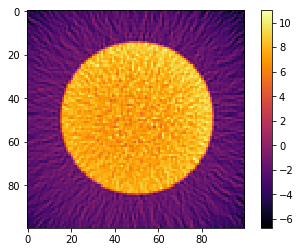

In [10]:
plt.imshow(recA[0], cmap='inferno', interpolation="none")
plt.colorbar()
plt.savefig('UnitCircle_noise0.png', dpi=600,
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=0.0,
        frameon=False)
plt.show()

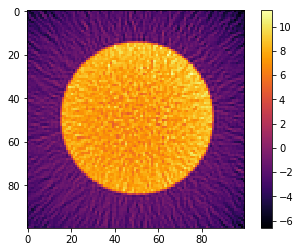

In [11]:
plt.imshow(recB[0], cmap='inferno', interpolation="none")
plt.colorbar()
plt.show()

## Calculate MTF

### Friedman's method
Use Friedman et al's method for computing the MTF. You can separate the MTF into multiple directions or average them all together using the `Ntheta` argument.

In [12]:
mtf_freq, mtf_value, labels = compute_mtf_ffst(p, recA[0], Ntheta=4)

The MTF is really a symmetric function around zero frequency, so usually people just show the positive portion. Sometimes, there is a peak at the higher spatial frequencies instead of the MTF approaching zero. This is probably because of aliasing noise content with frequencies higher than the Nyquist frequency. 

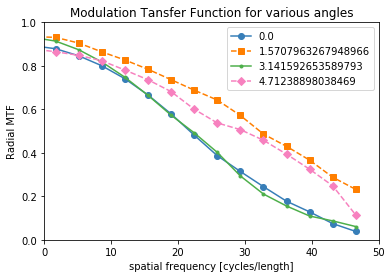

In [13]:
plot_mtf(mtf_freq, mtf_value, labels)
plt.gca().set_xlim([0,50]) # hide negative portion of MTF
plt.show()

### Siemens star method
You can also use a Siemens Star to calculate the MTF using a fitted sinusoidal method instead of the slanted edges that the above method uses.

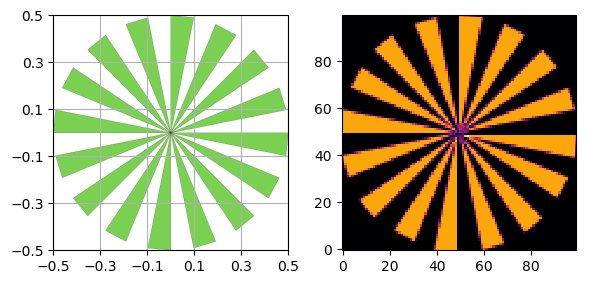

In [14]:
s = SiemensStar(n_sectors=32, center=Point([0, 0]), radius=0.5)
d = sidebyside(s, 100)
plt.show()

Here we are using the discreet verison of the phantom (without noise), so we are only limited by the resolution of the image.

In [15]:
mtf_freq, mtf_value = compute_mtf_lwkj(s, d)

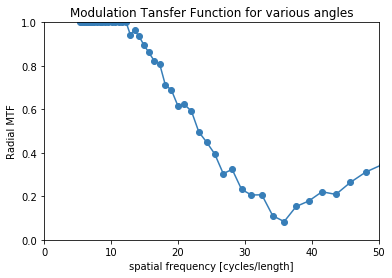

In [16]:
plot_mtf(mtf_freq, mtf_value, labels=None)
plt.gca().set_xlim([0,50]) # hide portion of MTF beyond Nyquist frequency
plt.show()

## Calculate NPS

Calculate the radial or 2D frequency plot of the NPS.

In [17]:
X, Y, NPS = compute_nps_ffst(p, recA[0], plot_type='frequency',B=recB[0])

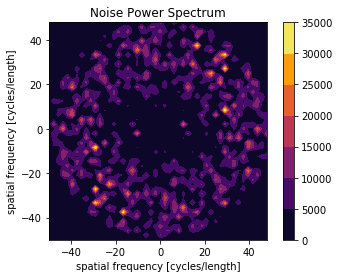

In [18]:
plot_nps(X, Y, NPS)
plt.show()

In [19]:
bins, counts = compute_nps_ffst(p, recA[0], plot_type='histogram',B=recB[0])

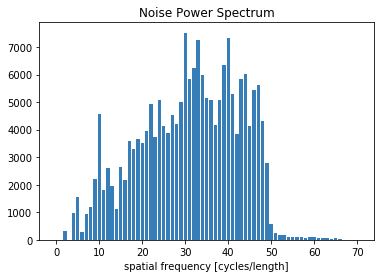

In [20]:
plt.figure()
plt.bar(bins, counts)
plt.xlabel('spatial frequency [cycles/length]')
plt.title('Noise Power Spectrum')
plt.show()

## Calculate NEQ

In [21]:
freq, NEQ = compute_neq_d(p, recA[0], recB[0])

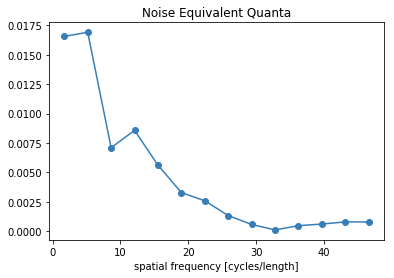

In [22]:
plt.figure()
plt.plot(freq.flatten(), NEQ.flatten())
plt.xlabel('spatial frequency [cycles/length]')
plt.title('Noise Equivalent Quanta')
plt.show()